## Loading Data from S3

In [2]:
!pip install patchify
!pip install segmentation-models==1.0.1
!pip install tensorflow
!pip install keras

You should consider upgrading via the '/usr/local/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python3.6 -m pip install --upgrade pip' command.
     |████████████████████████████████| 458.3 MB 10 kB/s s eta 0:00:01    |█▉                              | 25.5 MB 26.4 MB/s eta 0:00:17
     |████████████████████████████████| 5.6 MB 54.2 MB/s eta 0:00:01
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
     |████████████████████████████████| 462 kB 67.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 12.0 MB/s eta 0:00:01
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
     |████████████████████████████████| 4.0 MB 34.0 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 54.0 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 59.1 MB/s eta 0:00:01
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux201

In [3]:
# Importing Packages :
import os
import sys
import boto3
import subprocess
import io
import matplotlib.pyplot as plt
from patchify import patchify
import numpy as np
import segmentation_models as sm
from sklearn.model_selection import train_test_split

import configparser

Segmentation Models: using `keras` framework.


In [4]:
# Read the config file
# config = configparser.ConfigParser()
# config.read('aws_S3_full_access.cfg')

# Loading The Data:
s3 = boto3.resource(
   service_name='s3',
   region_name='us-east-1')



In [5]:
# Defining the DATA Location in the S3 bucket :
#default_location = "s3://appledatabucket/Apple/"
default_location = "s3://aws-sagemaker-image-segmentation-rotten-apple/data/"
print(default_location)    
print(os.listdir())
training_dir="Model"

s3://aws-sagemaker-image-segmentation-rotten-apple/data/
['Sagemaker_Deployment', 'Image_Segmentation.ipynb', '.git', 'requirements.txt', 'Image_Segmentation_Loading_S3.ipynb', '.ipynb_checkpoints', 'Notebook', 'Engine.py', 'README.md', 'MLPipeline']


# Getting Data From the Bucket

In [6]:
# Function To Load The Data
def loading_data(default_location):
    img_data_array = []
    mask_data_stack = []
    print("Reading the images")
    s3_bucket = "aws-sagemaker-image-segmentation-rotten-apple"
    keys = []
    for obj in s3.Bucket(s3_bucket).objects.all():
        keys.append(obj.key)
    for key in keys:
        file_stream = io.BytesIO()
        s3.Bucket(s3_bucket).Object(key).download_fileobj(file_stream)
        if ".jpg" in key and "data" in key:
            print(key)
            img = plt.imread(file_stream, format='jpg')
            print(img.shape)
            img_data_array.append(img)
        elif ".tiff" in key and "data" in key:
            mask = plt.imread(file_stream, format='tiff')
            print(mask.shape)
            mask_data_stack.append(mask)
    return img_data_array, mask_data_stack

In [7]:
# Getting Images and Mask:
img_data_array, mask_data_stack = loading_data(default_location)

Reading the images
data/1/1.jpg
(450, 720, 3)
(450, 720)
data/11/11.jpg
(406, 612, 3)
(406, 612)
data/12/12.jpg
(280, 334, 3)
(280, 334)
data/13/13.jpg
(216, 233, 3)
(216, 233)
data/14/14.jpg
(1300, 1300, 3)
(1300, 1300)
data/15/15.jpg
(153, 330, 3)
(153, 330)
data/16/16.jpg
(408, 612, 3)
(408, 612)
data/17/17.jpg
(606, 1024, 3)
(606, 1024)
data/18/18.jpg
(865, 1300, 3)
(865, 1300)
data/19/19.jpg
(866, 1300, 3)
(866, 1300)
data/2/2.jpg
(1000, 1778, 3)
(1000, 1778)
data/20/20.jpg
(957, 1300, 3)
(957, 1300)
data/21/21.jpg
(408, 612, 3)
(408, 612)
data/22/22.jpg
(1226, 1300, 3)
(1226, 1300)
data/23/23.jpg
(612, 612, 3)
(612, 612)
data/24/24.jpg
(443, 590, 3)
(443, 590)
data/25/25.jpg
(408, 612, 3)
(408, 612)
data/3/3.jpg
(193, 262, 3)
(193, 262)
data/4/4.jpg
(1226, 1300, 3)
(1226, 1300)
data/5/5.jpg
(183, 276, 3)
(183, 276)
data/6/6.jpg
(192, 262, 3)
(192, 262)
data/7/7.jpg
(280, 359, 3)
(280, 359)
data/8/8.jpg
(236, 214, 3)
(236, 214)
data/9/9.jpg
(900, 600, 3)
(900, 600)


# Patching the Images

In [8]:
# Function to Patch the Images:
def Image_Patching(img_data_array):
    all_img_patches = []
    shapes = []
    for img in range(len(img_data_array)):
        large_image = img_data_array[img]
        shapes.append(large_image.shape)
        patches_img = patchify(large_image, (128, 128, 3), step=128)
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i, j, :, :]
                single_patch_img = (single_patch_img.astype('float32')) / 255.
                all_img_patches.append(single_patch_img)
                    
    images = np.array(all_img_patches)
    images = np.reshape(images, (730, 128, 128, 3))
    return images

In [9]:
#Getting the Image Patches:
images = Image_Patching(img_data_array)

# Patching the Mask

In [10]:
# Function to patch the images:
def mask_patching(mask_data_stack):
    all_mask_patches = []
    for img in range(len(mask_data_stack)):
        large_mask = mask_data_stack[img]
        patches_mask = patchify(large_mask, (128, 128), step=128)
        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[i, j, :, :]
                single_patch_mask = single_patch_mask / 255.
                all_mask_patches.append(single_patch_mask)
                    
    masks = np.array(all_mask_patches)
    masks = np.expand_dims(masks, -1)
    return masks

In [11]:
#Getting the Mask Patches:
masks = mask_patching(mask_data_stack)

In [12]:
#Printing the Shapes of Images:
print("---Shape of the Images and Masks---")
print(images.shape)
print(masks.shape)
print("Pixel values in the mask are: ", np.unique(masks))

---Shape of the Images and Masks---
(730, 128, 128, 3)
(730, 128, 128, 1)
Pixel values in the mask are:  [0.         0.00392157]


In [13]:
# Building The Model:
BACKBONE = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE)
images1 = preprocess_input1(images) # Preprocessing the Image data in corresponding to the 'Resnet34' specification.
print(images1.shape)
print(masks.shape)

(730, 128, 128, 3)
(730, 128, 128, 1)


## Splitting the Dataset

In [14]:
# Splitting Data to Train and Test:
X_train, X_test, y_train, y_test = train_test_split(images1,
                                                        masks,
                                                        test_size=0.25, random_state=42)

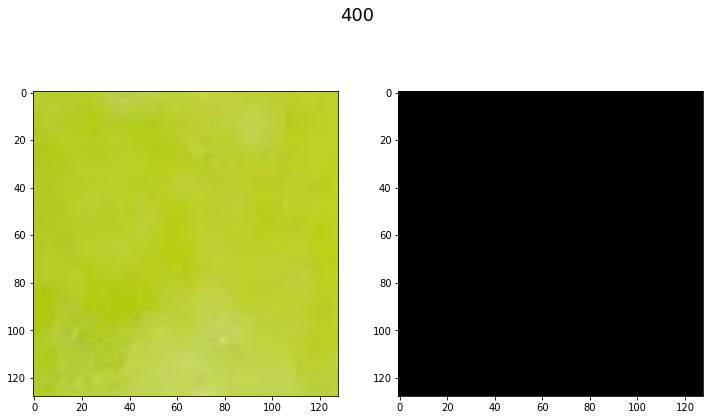

In [15]:
#Sanity check, view few mages
import random
import numpy as np

image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number, :,:,: ])

plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (128,128)), cmap='gray')
plt.suptitle(image_number, y=1.05, fontsize=18)

plt.show()

Augmentation of Image and Patches

In [16]:
seed=24
from tensorflow.keras.preprocessing.image import ImageDataGenerator
    

#Defining the ImageDataGenerator Parameters:
    
img_data_gen_args = dict(rotation_range=90,
                         width_shift_range=0.3,
                         height_shift_range=0.3,
                         shear_range=0.5,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                         width_shift_range=0.3,
                         height_shift_range=0.3,
                         shear_range=0.5,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect',
                         preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype))         

In [17]:
# important to make model take (128,128,n) formated images
import keras.backend as K
K.set_image_data_format('channels_last')

In [18]:
#Putting Images to the Generator for Augmentation:

image_data_generator = ImageDataGenerator(**img_data_gen_args) # Initialising the Image Generator Model
image_data_generator.fit(X_train, augment=True, seed=seed)
image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)  

In [19]:
#Putting Masks to the Generator for Augmentation:

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

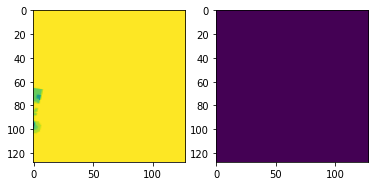

In [20]:
x = image_generator.next()
y = mask_generator.next()

for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

Image and Patches as Generator

In [21]:
def image_mask_generator(image_generator, mask_generator):
        train_generator = zip(image_generator, mask_generator)
        for (img, mask) in train_generator:
            yield (img, mask)

train_data_generator = image_mask_generator(image_generator, mask_generator)

validation_datagen = image_mask_generator(valid_img_generator, valid_mask_generator)

Compliling and Training the Model

In [22]:
# Defining the Model:
print("Loading the Model.....")

sm.set_framework('tf.keras')
sm.framework()

model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

#printing the Model:
print(model.summary())

Loading the Model.....
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
_____________________________________________________________________

In [23]:
steps_epoch=50
valid_step=50
epochs=50

In [24]:
# Training :
history = model.fit(train_data_generator,
                        validation_data = validation_datagen,
                        steps_per_epoch = steps_epoch,
                        validation_steps= valid_step,
                        epochs= epochs)

Epoch 1/50
25/50 [==============>...............] - ETA: 3:56 - loss: 1.1261 - iou_score: 0.2616

KeyboardInterrupt: 

In [ ]:
def iou_score(model):
        y_pred = model.predict(X_test)
        y_pred_thresholded = y_pred > 0.5
        intersection = np.logical_and(y_test, y_pred_thresholded)
        union = np.logical_or(y_test, y_pred_thresholded)
        iou_score = np.sum(intersection) / np.sum(union)
        return iou_score

In [ ]:
score = iou_score(model)
print("IoU socre is: ", score)

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['iou_score']
#acc = history.history['accuracy']
val_acc = history.history['val_iou_score']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

#Printing the IOU Score

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

In [ ]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
ground_truth=y_test[test_img_number]
prediction = model.predict(test_img_input)
prediction = prediction[0,:,:,0]


In [ ]:

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction)

plt.show()